In [1]:
import os ,yaml
from operator import itemgetter
from tools.import_data import *
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs

In [3]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True)
        try:
            cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=SCORING )
        except ValueError as e:
            print('ValueError{}'.format(None))
        else:
            scores.append(cv_results)
            names.append(name)
            results.append({"name":name,"score":cv_results.mean()})
            # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            # print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        # print('Model ' , name)
        # print('Accuracy: ', accuracy_score(Y_test, predictions))
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
        #print(confusion_matrix(Y_validation, predictions))
        # print(classification_report(Y_test, predictions))
    return results 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')
def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

# def information_gain(X, y):
#     def _entropy(labels):
#         counts = np.bincount(labels)
#         return entropy(counts, base=None)
# 
#     def _ig(x, y):
#         # indices where x is set/not set
#         x_set = np.nonzero(x)[1]
#         x_not_set = np.delete(np.arange(x.shape[1]), x_set)
# 
#         h_x_set = _entropy(y[x_set])
#         h_x_not_set = _entropy(y[x_not_set])
# 
#         return entropy_full - (((len(x_set) / f_size) * h_x_set)
#                              + ((len(x_not_set) / f_size) * h_x_not_set))
# 
#     entropy_full = _entropy(y)
# 
#     f_size = float(X.shape[0])
# 
#     scores = np.array([_ig(x, y) for x in X.T])
#     return scores

In [4]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = os.path.join(FILE_PATH,'config.yml')
config = yaml.load(open(CONFIG_FILE,'r'))
TRAIN_FILE = config['files']['train_set']
TEST_FILE = config['files']['test_set']
SCORING = config['score']

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)

Train data shape:  (776, 21)
Train labels shape:  (776,)


In [5]:
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_train.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            X_train_non_numeric = X_train.copy()
            X_train[c], label_mapping[c] = pd.factorize(X_train[c])
    imp = preprocessing.Imputer(axis=0, verbose=1)
    imp = imp.fit(X_train)
    X_train_imp = imp.transform(X_train)
    print ('New Train data shape: ',X_train_imp.shape)
    
    lb = preprocessing.LabelBinarizer()
    Y_train = lb.fit_transform(Y_train).ravel()
    
    fs_scores = fs.mutual_info_classif(X_train_imp,Y_train)
    feature_scores_list = []
    for i,score in enumerate(fs_scores):
        feature_scores_list.append({'feature_name':original_headers_train[i],'score':score})
    feature_scores_list.sort(key=itemgetter('score'),reverse=True)
    for feature in feature_scores_list:
        print (feature)

New Train data shape:  (776, 21)


{'feature_name': 'SYM_YRS_SINCE_HEARTBURN_START', 'score': 0.14387372569574319}
{'feature_name': 'SYM_YRS_SINCE_ACID_TASTE_START', 'score': 0.12504842422677376}
{'feature_name': 'SYM_TAKING_STOMACH_MEDS', 'score': 0.095795379704132877}
{'feature_name': 'SYM_CHEST_PAIN', 'score': 0.079350858872339503}
{'feature_name': 'WAIST_CIRCUMFERENCE', 'score': 0.073828213415438215}
{'feature_name': 'SEX', 'score': 0.056620323854597032}
{'feature_name': 'SYM_BURNING_CHEST', 'score': 0.054629074450502024}
{'feature_name': 'AGE', 'score': 0.051121062170279341}
{'feature_name': 'ALC_UNITS_PER_WEEK_AGED_30', 'score': 0.050674330514303145}
{'feature_name': 'HEIGHT', 'score': 0.049969936637284773}
{'feature_name': 'WEIGHT', 'score': 0.035340161438182527}
{'feature_name': 'SYM_SLEEP_DISRUPTED', 'score': 0.030392926811472876}
{'feature_name': 'SMK_EVER_SMOKED', 'score': 0.02941621662845062}
{'feature_name': 'SMK_AGE_SMOKING_STOPPED', 'score': 0.025476399889867052}
{'feature_name': 'SYM_ACID_TASTE', 'score'

In [7]:
    #before we found the elbow
    new_trains = []
    # new_shapes_ratio = []
    # new_range = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        # sel = fs.VarianceThreshold(VTHRESH)
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        # sel.fit(X_train_imp,Y_train)
        # print (sel.get_params())
        # print (sel.get_support())
        X_train_mod = sel.fit_transform(X_train_imp,Y_train)
        if len(new_trains) >= 1:
            if new_trains[-1]['ratio']!= X_train_mod.shape[-1]/X_train.shape[-1]:
                # new_range.append(VTHRESH)
                # new_trains.append(X_train_mod)
                # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
                mask = sel.get_support() #list of booleans
                new_features = [] # The list of your K best features    
                for bool, feature in zip(mask, original_headers_train):
                    if bool:
                        new_features.append(feature)
                new_trains.append({'threshold':VTHRESH,
                                   'X_train':X_train_mod,
                                   'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                                   'features_name':new_features})
                
        else:
            # new_range.append(VTHRESH)
            # new_trains.append(X_train_mod)
            # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
            mask = sel.get_support() #list of booleans
            new_features = [] # The list of your K best features    
            for bool, feature in zip(mask, original_headers_train):
                if bool:
                    new_features.append(feature)
            new_trains.append({'threshold':VTHRESH,
                               'X_train':X_train_mod,
                               'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                               'features_name':new_features})

**Training Section** for: 1 features (['SYM_YRS_SINCE_ACID_TASTE_START'])

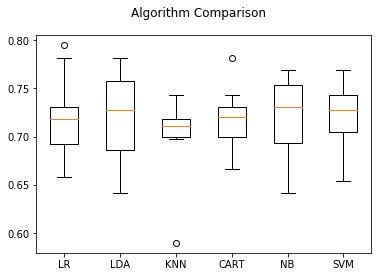

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.723043184885</span>

{'name': 'LR', 'score': 0.72010796221322537}
{'name': 'LDA', 'score': 0.72051282051282062}
{'name': 'KNN', 'score': 0.70229419703103924}
{'name': 'CART', 'score': 0.71902834008097161}
{'name': 'NB', 'score': 0.72041160593792175}
{'name': 'SVM', 'score': 0.72304318488529018}


**Training Section** for: 2 features (['SEX', 'SYM_YRS_SINCE_HEARTBURN_START'])

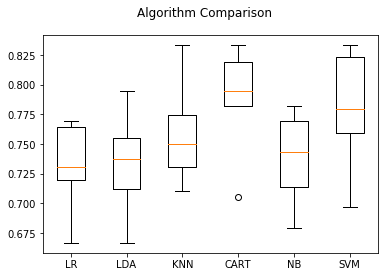

The best model for the given data is: <span style="color:green">CART</span> with the score <span style="color:green">0.793960863698</span>

{'name': 'LR', 'score': 0.73198380566801624}
{'name': 'LDA', 'score': 0.73323211875843453}
{'name': 'KNN', 'score': 0.75637651821862339}
{'name': 'CART', 'score': 0.7939608636977058}
{'name': 'NB', 'score': 0.73957489878542515}
{'name': 'SVM', 'score': 0.7807017543859649}


**Training Section** for: 3 features (['SEX', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START'])

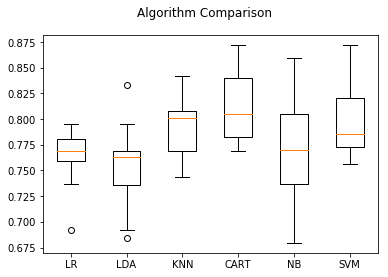

The best model for the given data is: <span style="color:green">CART</span> with the score <span style="color:green">0.810458839406</span>

{'name': 'LR', 'score': 0.76413630229419693}
{'name': 'LDA', 'score': 0.75495951417004048}
{'name': 'KNN', 'score': 0.79406207827260455}
{'name': 'CART', 'score': 0.81045883940620789}
{'name': 'NB', 'score': 0.76804993252361675}
{'name': 'SVM', 'score': 0.80141700404858296}


**Training Section** for: 4 features (['WAIST_CIRCUMFERENCE', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

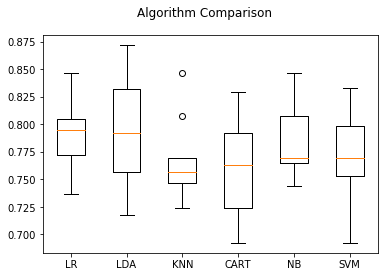

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.790114709852</span>

{'name': 'LR', 'score': 0.78987854251012146}
{'name': 'LDA', 'score': 0.79011470985155208}
{'name': 'KNN', 'score': 0.76524966261808369}
{'name': 'CART', 'score': 0.75934547908232131}
{'name': 'NB', 'score': 0.7848852901484481}
{'name': 'SVM', 'score': 0.77182860998650482}


**Training Section** for: 5 features (['SEX', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

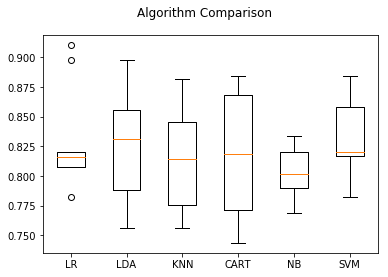

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.832489878543</span>

{'name': 'LR', 'score': 0.82854251012145741}
{'name': 'LDA', 'score': 0.82584345479082322}
{'name': 'KNN', 'score': 0.81339406207827269}
{'name': 'CART', 'score': 0.81693657219973015}
{'name': 'NB', 'score': 0.8040485829959515}
{'name': 'SVM', 'score': 0.83248987854251}


**Training Section** for: 6 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

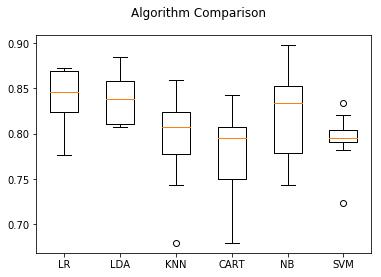

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.839946018893</span>

{'name': 'LR', 'score': 0.83994601889338727}
{'name': 'LDA', 'score': 0.83896761133603237}
{'name': 'KNN', 'score': 0.79385964912280693}
{'name': 'CART', 'score': 0.77860998650472335}
{'name': 'NB', 'score': 0.82334682860998643}
{'name': 'SVM', 'score': 0.79362348178137654}


**Training Section** for: 7 features (['SEX', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

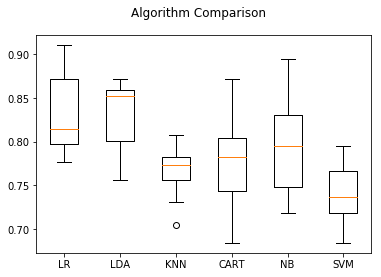

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.834817813765</span>

{'name': 'LR', 'score': 0.83481781376518216}
{'name': 'LDA', 'score': 0.83221997300944683}
{'name': 'KNN', 'score': 0.76555330634277996}
{'name': 'CART', 'score': 0.77692307692307694}
{'name': 'NB', 'score': 0.79784075573549251}
{'name': 'SVM', 'score': 0.74075573549257756}


**Training Section** for: 8 features (['SEX', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

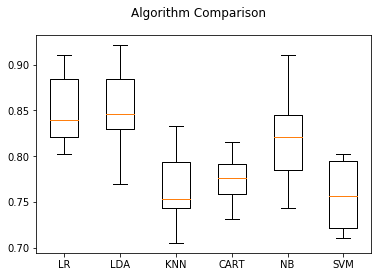

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.853205128205</span>

{'name': 'LR', 'score': 0.85026990553306336}
{'name': 'LDA', 'score': 0.85320512820512828}
{'name': 'KNN', 'score': 0.7654858299595142}
{'name': 'CART', 'score': 0.77584345479082317}
{'name': 'NB', 'score': 0.82081646423751686}
{'name': 'SVM', 'score': 0.75772604588394055}


**Training Section** for: 9 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

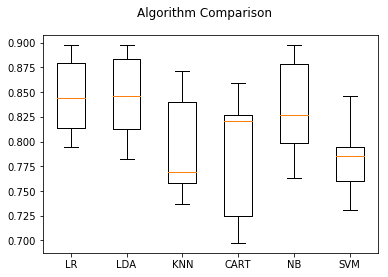

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.845479082321</span>

{'name': 'LR', 'score': 0.84547908232118751}
{'name': 'LDA', 'score': 0.84541160593792175}
{'name': 'KNN', 'score': 0.79230769230769238}
{'name': 'CART', 'score': 0.78468286099865048}
{'name': 'NB', 'score': 0.83245614035087723}
{'name': 'SVM', 'score': 0.78228744939271255}


**Training Section** for: 10 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

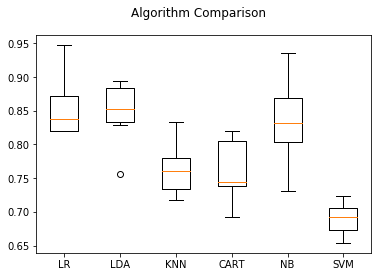

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.85205802969</span>

{'name': 'LR', 'score': 0.85205802968960875}
{'name': 'LDA', 'score': 0.85057354925775974}
{'name': 'KNN', 'score': 0.7642375168690958}
{'name': 'CART', 'score': 0.76167341430499325}
{'name': 'NB', 'score': 0.83498650472334679}
{'name': 'SVM', 'score': 0.69075573549257763}


**Training Section** for: 11 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

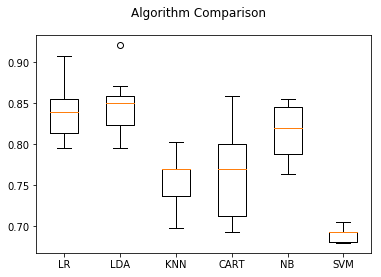

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.846862348178</span>

{'name': 'LR', 'score': 0.84028340080971664}
{'name': 'LDA', 'score': 0.84686234817813744}
{'name': 'KNN', 'score': 0.75512820512820511}
{'name': 'CART', 'score': 0.76278677462887978}
{'name': 'NB', 'score': 0.81568825910931175}
{'name': 'SVM', 'score': 0.68943994601889336}


**Training Section** for: 12 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

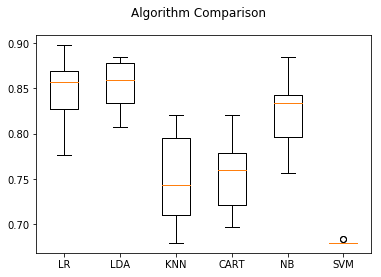

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.851923076923</span>

{'name': 'LR', 'score': 0.84777327935222679}
{'name': 'LDA', 'score': 0.85192307692307678}
{'name': 'KNN', 'score': 0.74979757085020238}
{'name': 'CART', 'score': 0.75502699055330635}
{'name': 'NB', 'score': 0.82206477732793515}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 13 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

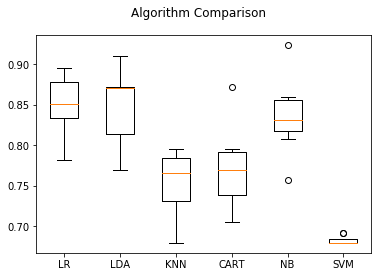

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.850641025641</span>

{'name': 'LR', 'score': 0.85064102564102573}
{'name': 'LDA', 'score': 0.8504385964912281}
{'name': 'KNN', 'score': 0.7526990553306343}
{'name': 'CART', 'score': 0.7691295546558703}
{'name': 'NB', 'score': 0.83498650472334679}
{'name': 'SVM', 'score': 0.68299595141700409}


**Training Section** for: 14 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

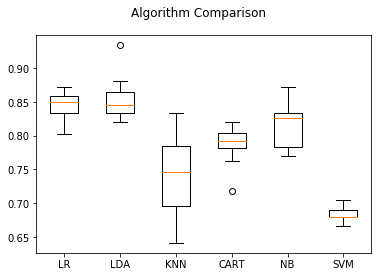

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.854655870445</span>

{'name': 'LR', 'score': 0.84399460188933872}
{'name': 'LDA', 'score': 0.85465587044534408}
{'name': 'KNN', 'score': 0.7421390013495277}
{'name': 'CART', 'score': 0.78603238866396774}
{'name': 'NB', 'score': 0.81575573549257763}
{'name': 'SVM', 'score': 0.68431174089068825}


**Training Section** for: 15 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

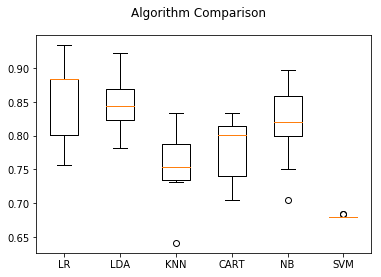

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.850843454791</span>

{'name': 'LR', 'score': 0.85084345479082324}
{'name': 'LDA', 'score': 0.84531039136302299}
{'name': 'KNN', 'score': 0.75526315789473686}
{'name': 'CART', 'score': 0.78087044534412953}
{'name': 'NB', 'score': 0.82068151147098511}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 16 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

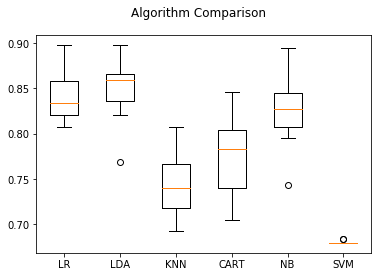

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.849257759784</span>

{'name': 'LR', 'score': 0.84018218623481788}
{'name': 'LDA', 'score': 0.84925775978407558}
{'name': 'KNN', 'score': 0.7423751686909581}
{'name': 'CART', 'score': 0.77580971659919018}
{'name': 'NB', 'score': 0.82496626180836707}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 17 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

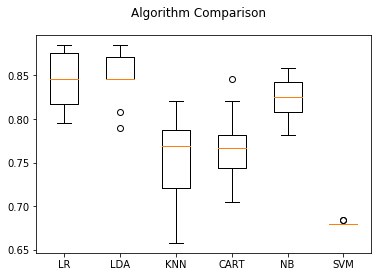

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.847840755735</span>

{'name': 'LR', 'score': 0.84409581646423748}
{'name': 'LDA', 'score': 0.84784075573549278}
{'name': 'KNN', 'score': 0.75242914979757081}
{'name': 'CART', 'score': 0.767948717948718}
{'name': 'NB', 'score': 0.82209851551956814}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 18 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

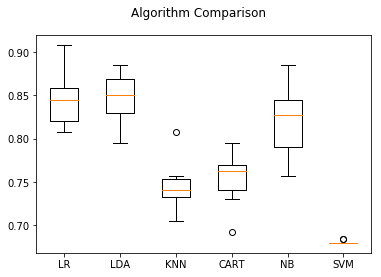

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.848076923077</span>

{'name': 'LR', 'score': 0.84807692307692295}
{'name': 'LDA', 'score': 0.84662618083670726}
{'name': 'KNN', 'score': 0.74352226720647763}
{'name': 'CART', 'score': 0.75509446693657212}
{'name': 'NB', 'score': 0.82348178137651806}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 19 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

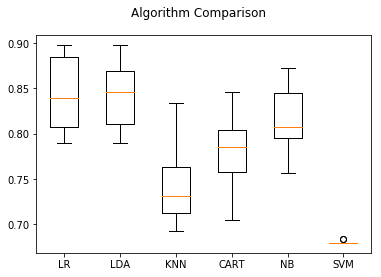

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.845344129555</span>

{'name': 'LR', 'score': 0.84534412955465577}
{'name': 'LDA', 'score': 0.84122807017543866}
{'name': 'KNN', 'score': 0.74493927125506076}
{'name': 'CART', 'score': 0.77834008097166008}
{'name': 'NB', 'score': 0.81828609986504719}
{'name': 'SVM', 'score': 0.68043184885290153}


**Training Section** for: 20 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

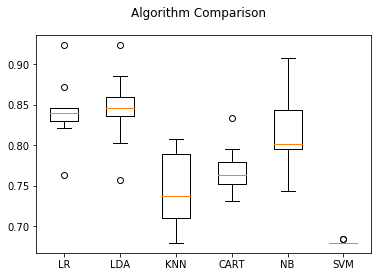

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.84524291498</span>

{'name': 'LR', 'score': 0.84126180836707165}
{'name': 'LDA', 'score': 0.84524291497975701}
{'name': 'KNN', 'score': 0.74466936572199738}
{'name': 'CART', 'score': 0.76923076923076927}
{'name': 'NB', 'score': 0.81585695006747638}
{'name': 'SVM', 'score': 0.68043184885290153}


In [8]:
    best_tr_results = []
    # new_trains.reverse()
    new_models = []
    for train_set in new_trains:
        X_train_mod = train_set['X_train']
        printmd("**Training Section** for: {} features ({})".format(str(X_train_mod.shape[-1]),train_set['features_name']))
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        new_models.append({'train_set':train_set,'train_resultes':train_resultes})
        if train_resultes:
            best_tr = get_the_best(train_resultes)
            best_tr_results.append({"name":best_tr['name'],
                                    "score":best_tr['score'],
                                    "num_fetures":int(X_train_mod.shape[-1]),
                                    'features_names':train_set['features_name']})
            for model in train_resultes:
                print (model)

In [9]:
    best_tr_results.sort(key=itemgetter('score'),reverse=True)
    for best in best_tr_results:
        print(best)
    plt.plot([d['threshold'] for d in new_trains],
             [d['ratio'] for d in new_trains],
             [rs['score'] for rs in best_tr_results])

{'name': 'LDA', 'score': 0.85465587044534408, 'num_fetures': 14, 'features_names': ['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LDA', 'score': 0.85320512820512828, 'num_fetures': 8, 'features_names': ['SEX', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LR', 'score': 0.85205802968960875, 'num_fetures': 10, 'features_names': ['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LDA', 'score': 0.85192307692307678

**Training Section** for: 418976 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


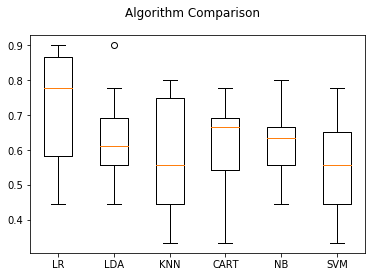

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444444</span>

{'name': 'LR', 'score': 0.7144444444444444}
{'name': 'LDA', 'score': 0.6266666666666667}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.62}
{'name': 'NB', 'score': 0.6177777777777778}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 300021 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


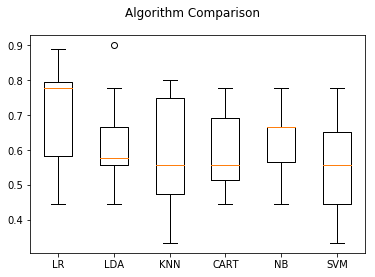

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6166666666666666}
{'name': 'KNN', 'score': 0.5822222222222222}
{'name': 'CART', 'score': 0.5977777777777777}
{'name': 'NB', 'score': 0.6211111111111112}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 249789 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


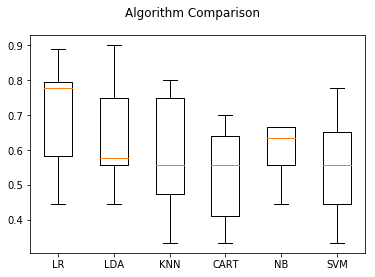

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6277777777777778}
{'name': 'KNN', 'score': 0.5933333333333334}
{'name': 'CART', 'score': 0.5211111111111111}
{'name': 'NB', 'score': 0.598888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 212518 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


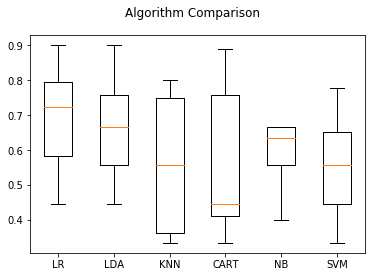

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6922222222222223</span>

{'name': 'LR', 'score': 0.6922222222222223}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.56}
{'name': 'CART', 'score': 0.5544444444444444}
{'name': 'NB', 'score': 0.5888888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 181350 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


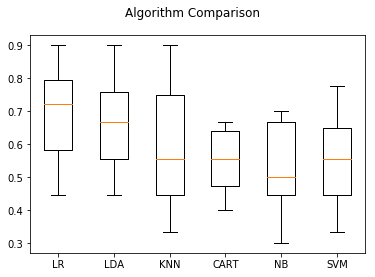

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.5811111111111111}
{'name': 'CART', 'score': 0.5466666666666666}
{'name': 'NB', 'score': 0.5333333333333334}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 153725 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


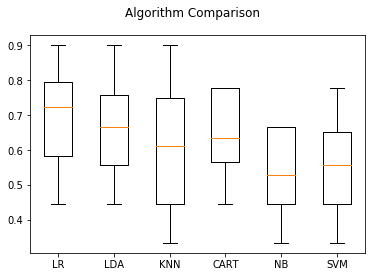

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6599999999999999}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6533333333333333}
{'name': 'NB', 'score': 0.5344444444444444}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 129439 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


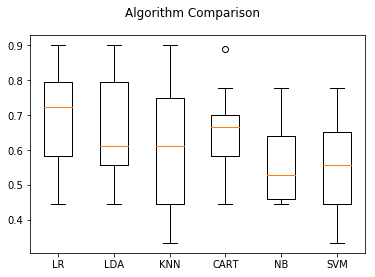

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6622222222222222}
{'name': 'NB', 'score': 0.5555555555555556}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 108368 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


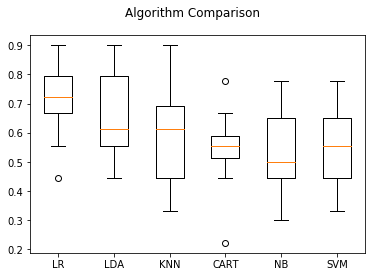

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444445</span>

{'name': 'LR', 'score': 0.7144444444444445}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.5433333333333333}
{'name': 'NB', 'score': 0.5344444444444445}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 90282 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)